In [ ]:
# Code prepared by Tomas Jochym-O'Connor (IBM Research)

In [2]:
import sys
import numpy as np
import random
import array as arr
import scipy
from scipy.sparse import coo_matrix as coo_matrix
from scipy.sparse import csr_matrix as csr_matrix
from scipy.sparse import csc_matrix as csc_matrix
from scipy.sparse import lil_matrix as lil_matrix
from timeit import default_timer as timer
import time
#import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from numpy.linalg import matrix_rank
from numpy.linalg import matrix_power as m_power
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize) # removes truncation of arrays

In [3]:
# matrix rank over GF(2) (Taken from T. Yoder)
def matrixRank(mat):
    M=mat.copy() # mat should be an np.array
    m=len(M) # number of rows
    pivots={} # dictionary mapping pivot row --> pivot column
    # row reduction
    for row in range(m):
        pos = next((index for index,value in enumerate(M[row]) if value != 0), -1) #finds position of first nonzero element (or -1 if all 0s)
        if pos>-1:
            for row2 in range(m):
                if row2!=row and M[row2][pos]==1:
                    M[row2]=((M[row2]+M[row]) % 2)
            pivots[row]=pos
    return len(pivots)

def nullspaceMod2(mat):
    M=mat.copy() #mat should be an np.array
    shape=M.shape
    m=shape[0]
    n=shape[1]
    pivots={} #dictionary mapping pivot row --> pivot column
    nonpivot_columns=list(range(n)) #keeps track of columns that *aren't* items in pivots
    # row reduction
    for row in range(m):
        pos = next((index for index,value in enumerate(M[row]) if value != 0), -1) #finds position of first nonzero element (or -1 if all 0s)
        if pos>-1:
            for row2 in range(m):
                if row2!=row and M[row2][pos]==1:
                    M[row2]=((M[row2]+M[row]) % 2)
            pivots[row]=pos
            nonpivot_columns[pos]=-1
    nonpivot_columns = [x for x in nonpivot_columns if x>-1]
    rank = len(pivots)
    nullrank = n - rank #=len(nonpivot_columns)
    # go through the nonpivot columns to get a basis for the nullspace
    nullspace = np.zeros((nullrank,n),dtype=int)
    for i in range(nullrank):
        col = nonpivot_columns[i]
        nullspace[i][col]=1
        for j in range(m):
            if M[j][col] == 1:
                nullspace[i][pivots[j]]=1
    return nullspace


def CSSlogicals(Hx,Hz): #This function outputs a set of conjugate paired logicals for X and Z
    
    HxNull = nullspaceMod2(Hx)
    HzNull = nullspaceMod2(Hz)
    n = len(HxNull[0])
    
    M = np.matmul(HxNull,np.transpose(HzNull)) % 2
    shape=M.shape
    m=shape[0]
    #n=shape[1]
    pivots={} #dictionary mapping pivot row --> pivot column
    nonpivot_columns=list(range(n)) #keeps track of columns that *aren't* items in pivots
    # row reduction
    for row in range(m):
        pos = next((index for index,value in enumerate(M[row]) if value != 0), -1) #finds position of first nonzero element (or -1 if all 0s)
        if pos>-1:
            for row2 in range(m):
                if row2!=row and M[row2][pos]==1:
                    M[row2]=((M[row2]+M[row]) % 2)
                    HxNull[row2]=((HxNull[row2]+HxNull[row]) % 2)
            pivots[row]=pos
    
    Lx = np.zeros((len(pivots),n),dtype=int)
    Lz = np.zeros((len(pivots),n),dtype=int)
    pivotrows = list(pivots)
    for j in range(0,len(pivots)):
        row = pivotrows[j]
        Lz[j] = HxNull[row]
        Lx[j] = HzNull[pivots[row]]
        
    return Lx, Lz

def StabLogicals(S): 
    # This functino outputs a set of conjugate paired logicals for a general stabilzer code 
    # H is the parity check matrix of the code in binary-simplectic form
    
    n = int(len(S[0])/2)
    Sn = nullspaceMod2(S)
    P_null = np.hstack((Sn[:,n:2*n],Sn[:,0:n]))
    
    M = np.matmul(P_null,np.transpose(Sn)) % 2
    m = len(M[0])
    pivots={}
    # row reduction
    for row in range(m):
        pos = next((index for index,value in enumerate(M[row]) if value != 0), -1) #finds position of first nonzero element (or -1 if all 0s)
        if pos>-1:
            for row2 in range(m):
                if row2!=row and M[row2][pos]==1:
                    #M[row2]=((M[row2]+M[row]) % 2)
                    P_null[row2]=((P_null[row2]+P_null[row]) % 2)
                    Sn[row2]=(Sn[row2]+Sn[row]) % 2
                    M = np.matmul(P_null,np.transpose(Sn)) % 2
            pivots[row]=pos
            
    Lx = np.zeros((len(pivots),2*n),dtype=int)
    Lz = np.zeros((len(pivots),2*n),dtype=int)
    pivotrows = list(pivots)
    for j in range(0,len(pivots)):
        row = pivotrows[j]
        Lz[j] = P_null[row]
        Lx[j] = P_null[pivots[row]]
        
    return Lx, Lz

def anticommute(P,Q):
    # This takes as input two Pauli operators P,Q in binary symplectic form
    # outputs 1 if they anticommute, 0 if they commute 
    
    n = int(len(P)/2)
    out = 0
    for j in range(0,n):
        out = (out + P[j]*Q[j+n] + P[j+n]*Q[j]) % 2
        
    return out

def StabilizerUpdate(S,M):
    # S, M should be np.array
    # This takes as input a commuting stabilizer group S and Pauli operator M
    # The input is in binary-symplectic form for both
    
    row = -1
    for j in range(0,len(S)):
        if anticommute(S[j],M[0]):
            row = j
            break
        
    if row>-1:
        for j in range(row+1,len(S)):
            if anticommute(S[j],M[0]):
                S[j] = (S[j] + S[row]) % 2
                
        S[row] = M[0]
        

    
    
    

In [4]:
### Defining identity and cyclic shift matrices to be used in code constructions
def Sd(m):
    M = np.zeros((m,m),dtype=int)
    
    for j in range(0,m):
        M[j,np.mod(j+1,m)] = 1
        
    return M

def Id(m):
    M = np.zeros((m,m),dtype=int)
    
    for j in range(0,m):
        M[j,j] = 1
        
    return M

In [5]:
### Constructing the BB codes
### Gross code: l=12, m=6, a=2, b=3, c=3, d=5

z = 1
l = 12
m = 6
a = 2*z
b = 3*z
c = 3*z
d = 5*z
x = np.kron(Sd(l),Id(m))
y = np.kron(Id(l),Sd(m))
#A = np.mod(Id(l*m)+y+np.matmul(m_power(y,a),m_power(x,b)),2)
#B = np.mod(Id(l*m)+x+np.matmul(m_power(y,c),m_power(x,d)),2)
A = np.mod(m_power(x,3)+y+m_power(y,2),2)
B = np.mod(m_power(y,3)+x+m_power(x,2),2)
Hx = np.hstack((A,B))
Hz = np.hstack((np.transpose(B),np.transpose(A)))
print(A)
print(B)
print(2*l*m)
#print(matrixRank(A))
#print(matrixRank(B))
print(matrixRank(Hx))
print(matrixRank(Hz))
#A = A1 + A2 + A3
#B = B1 + B2 + B3

[[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [6]:
### Define Gross code logicals
f = Id(l*m)+x+m_power(x,2)+m_power(x,3)+m_power(x,6)+m_power(x,7)+m_power(x,8)+m_power(x,9)+np.matmul(m_power(y,3),m_power(x,1))+np.matmul(m_power(y,3),m_power(x,5))+np.matmul(m_power(y,3),m_power(x,7))+np.matmul(m_power(y,3),m_power(x,11))
g = x +np.matmul(m_power(y,1),m_power(x,2)) +m_power(y,2) +np.matmul(m_power(y,2),m_power(x,1)) +np.matmul(m_power(y,3),m_power(x,2)) +m_power(y,4)
h = Id(l*m) + y +np.matmul(m_power(y,1),m_power(x,1)) +m_power(y,2) +m_power(y,3) +np.matmul(m_power(y,3),m_power(x,1))
xL_f = np.hstack((f,np.zeros((72,72),dtype=int)))
zL_hg = np.hstack((np.transpose(h),np.transpose(g)))
#print(Hx.shape)
#print(xL_f.shape)
#print(xL_f[0])
#print(y.shape)

# Lx and Lz will store the logical X and Z Pauli matrices
Lx = np.zeros((12,144),dtype=int)
Lz = np.zeros((12,144),dtype=int)

Lx[0] = np.hstack((f,np.zeros((72,72),dtype=int)))[0]
alpha = y
Lx[1] = np.hstack((np.matmul(alpha,f),np.zeros((72,72),dtype=int)))[0]
alpha = np.matmul(m_power(x,2),m_power(y,1))
Lx[2] = np.hstack((np.matmul(alpha,f),np.zeros((72,72),dtype=int)))[0]
alpha = np.matmul(m_power(x,2),m_power(y,5))
Lx[3] = np.hstack((np.matmul(alpha,f),np.zeros((72,72),dtype=int)))[0]
alpha = np.matmul(m_power(x,3),m_power(y,2))
Lx[4] = np.hstack((np.matmul(alpha,f),np.zeros((72,72),dtype=int)))[0]
alpha = m_power(x,4)
Lx[5] = np.hstack((np.matmul(alpha,f),np.zeros((72,72),dtype=int)))[0]

gh = np.hstack((g,h))
alpha = Id(l*m)
Lx[6] = np.matmul(alpha,gh)[0]
alpha = y
Lx[7] = np.matmul(alpha,gh)[0]
alpha = np.matmul(m_power(x,2),m_power(y,1))
Lx[8] = np.matmul(alpha,gh)[0]
alpha = np.matmul(m_power(x,2),m_power(y,5))
Lx[9] = np.matmul(alpha,gh)[0]
alpha = np.matmul(m_power(x,3),m_power(y,2))
Lx[10] = np.matmul(alpha,gh)[0]
alpha = m_power(x,4)
Lx[11] = np.matmul(alpha,gh)[0]


hgT = np.hstack((np.transpose(h),np.transpose(g)))
alpha = y
Lz[0] = np.matmul(alpha,hgT)[0]
alpha = m_power(y,5)
Lz[1] = np.matmul(alpha,hgT)[0]
alpha = np.matmul(m_power(x,1),m_power(y,1))
Lz[2] = np.matmul(alpha,hgT)[0]
alpha = Id(l*m)
Lz[3] = np.matmul(alpha,hgT)[0]
alpha = m_power(x,4)
Lz[4] = np.matmul(alpha,hgT)[0]
alpha = np.matmul(m_power(x,5),m_power(y,2))
Lz[5] = np.matmul(alpha,hgT)[0]

fT = np.hstack((np.zeros((72,72),dtype=int),np.transpose(f)))
alpha = y
Lz[6] = np.matmul(alpha,fT)[0]
alpha = m_power(y,5)
Lz[7] = np.matmul(alpha,fT)[0]
alpha = np.matmul(m_power(x,1),m_power(y,1))
Lz[8] = np.matmul(alpha,fT)[0]
alpha = Id(l*m)
Lz[9] = np.matmul(alpha,fT)[0]
alpha = m_power(x,4)
Lz[10] = np.matmul(alpha,fT)[0]
alpha = np.matmul(m_power(x,5),m_power(y,2))
Lz[11] = np.matmul(alpha,fT)[0]

print('Check that the logicals have the right commutation with parity checks and other logicals:')
print(np.matmul(Hz,np.transpose(Lx)) % 2)
print(np.matmul(Hx,np.transpose(Lz)) % 2)
print(np.matmul(Lx,np.transpose(Lz)) % 2)

Check that the logicals have the right commutation with parity checks and other logicals:
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0

In [14]:
# General technique for decoding logicals of a stabilizer code via single-qubit measurement
def SingleQMeasurementDecoding(SMat,LMat):
    
    # Inputs: SMat, LMat are matrices of the stabilizer generators and logicals in binary symplectic form
    # Assuming that the first k rows of LMat are logical X operators, and second k rows are logical Zs (might not be needed)
    
    S = SMat.copy()
    L = LMat.copy()
    n = int(len(S[0])/2) # Number of physical qubits
    k = int(len(L)/2)    # Number of logical qubits
    m = len(S)           # Number of stabilizer elements (not generators as it may be overcomplete)
    Xmeasured = []
    Zmeasured = []
    
    SL = np.vstack((S,L)) # Stabilizers + Logicals in binary symplectic form
    
    for i in range(0,m):
        # Find first non-trivial element of the i-th stabilizer
        q = -1
        for j in range(0,n):
            if S[i,j] == 1 or S[i,j+n] == 1:
                q = j
            if q != -1:
                break
        
        # Keep track of which qubit is being measured
        # Measure in the complementary basis, X if Z/Y support, Z if X support
        P = np.zeros((1,2*n),dtype = int) 
        if S[i,q+n] == 1:
            Xmeasured.append(q)
            P[0,q] = 1
        elif S[i,q] == 1:
            Zmeasured.append(q)
            P[0,q+n] = 1
        
        StabilizerUpdate(S,P)  # Update the tableau for S with the measurement of P   
        StabilizerUpdate(SL,P) # Update the tableau for SL with the measurement of P
        
        
        # Stabilizers have been updated, remove the support of new single-qubit stabilizer from remaining stabs
        for i2 in range(i+1,m+2*k):
            if SL[i2,q] == 1 or SL[i2,q+n] == 1:
                #SL[i2] = np.add(SL[i2],P) % 2
                if i2 < m:
                    S[i2] = np.add(S[i2],P) % 2
                    SL[i2] = np.add(SL[i2],P) % 2
                    
    SingleLogicals = [x for x in range(0,n) if x not in (Xmeasured + Zmeasured)]
    
        
    return S,SL,SingleLogicals,Xmeasured,Zmeasured
        
        
    

In [15]:
# Code for converting CSS definitions into general binary symplectic form for general stabilizer codes
n = len(Hx[0])
k = len(Lx)
Sx = np.hstack((Hx,np.zeros((len(Hx),n),dtype = int))) # These are the X stabilizers written in binary symplectic form
Sz = np.hstack((np.zeros((len(Hz),n),dtype = int),Hz)) # These are the Z stabilizers written in binary symplectic form
S = np.vstack((Sx,Sz))
L = np.vstack((np.hstack((Lx,np.zeros((k,n),dtype = int))),np.hstack((np.zeros((k,n),dtype = int),Lz)))) # Logicals written in binary symplectic form
SL = np.vstack((S,L))
S_dec,SL_dec,SingleLogicals,Xmeasured,Zmeasured = SingleQMeasurementDecoding(S,L)

In [16]:
print("The qubits that will store the logical information:")
print(SingleLogicals)
print("The qubits to be prepared in X:")
print(Xmeasured)
print("The qubits to be prepared in Z:")
print(Zmeasured)
print("Checking to see if the new logicals retain the right commutation relations with stabs and other loticals:")
print(np.matmul(SL_dec[144:156,0:144],np.transpose(SL_dec[156:168,144:288])) % 2)

The qubits that will store the logical information:
[130, 131, 132, 133, 134, 135, 136, 137, 140, 141, 142, 143]
The qubits to be prepared in X:
[76, 77, 62, 63, 64, 65, 82, 83, 68, 69, 70, 71, 88, 84, 85, 86, 87, 138, 94, 90, 91, 92, 93, 126, 100, 96, 80, 81, 98, 99, 89, 102, 103, 104, 105, 139, 95, 108, 109, 110, 111, 127, 101, 97, 114, 115, 116, 117, 106, 107, 120, 122, 123, 121, 57, 58, 59, 113, 112, 56, 118, 119, 128, 129, 124, 125]
The qubits to be prepared in Z:
[1, 2, 3, 4, 0, 18, 7, 8, 9, 10, 6, 24, 13, 14, 15, 16, 12, 30, 19, 20, 21, 22, 36, 37, 25, 26, 27, 28, 42, 43, 31, 32, 33, 34, 48, 49, 38, 41, 39, 40, 54, 55, 44, 47, 45, 46, 60, 61, 50, 53, 51, 52, 66, 67, 5, 23, 72, 74, 75, 73, 11, 29, 78, 79, 17, 35]
Checking to see if the new logicals retain the right commutation relations with stabs and other loticals:
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0

Examples of stabilizers for the Gross code:


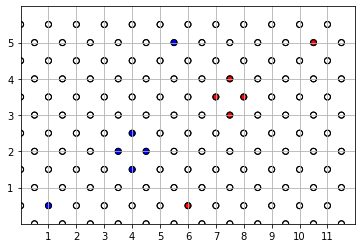

In [8]:
# Printing out example stabilizers of the gross code
x = []
y = []
for j in range(0,72):
    x.append(1/2 + np.floor(j/6))
    y.append((3-j) % 6)
for j in range(0,72):
    x.append((np.floor(j/6)-1) % 12)
    y.append(((-j % 6) + 3/2) % 6)
#print(x)
#print(y)

#print(Hx[0])
#print(Hx[1])
#print(Hx[2])
#print(Hx[3])
#print(Hx[4])
#print(Hx[5])
#print(Hx[6])
Xcolors = []
Zcolors = []
for j in range(0,len(x)):
    if Hx[46,j] == 0:
        Xcolors.append('none')
    else:
        if Hz[31,j] == 0:
            Xcolors.append('red')
        else:
            Xcolors.append('green')
    
    if Hz[31,j] == 0:
        Zcolors.append('none')
    else:
        if Hx[46,j] == 0:
            Zcolors.append('blue')
        else:
            Zcolors.append('green')

# plot
fig, ax = plt.subplots()

ax.scatter(x, y, facecolors=Xcolors, edgecolors='black')
ax.scatter(x, y, facecolors=Zcolors, edgecolors='black')

ax.set(xlim=(0, 12), xticks=np.arange(1, 12),
       ylim=(0, 6), yticks=np.arange(1, 6))

ax.grid(True)

# Uncomment below if you would like to save the figure
plt.savefig("./TMP/GrossStabs.png",dpi=300)
print('Examples of stabilizers for the Gross code:')
plt.show()


X logicals of the Gross code:


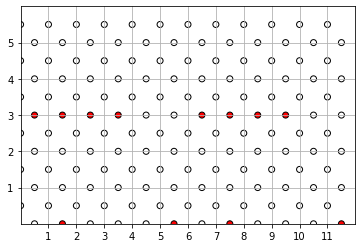

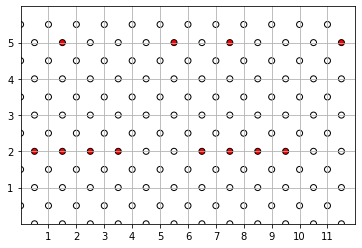

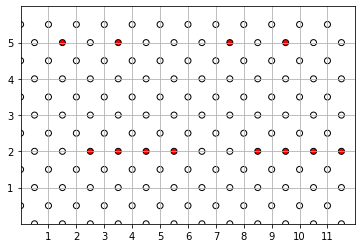

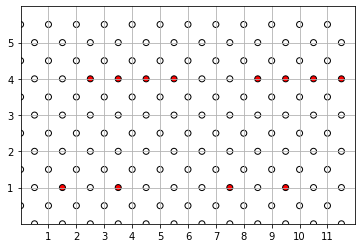

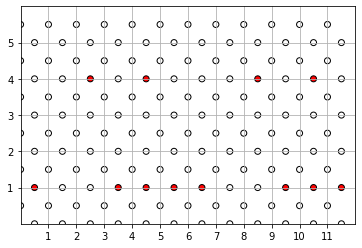

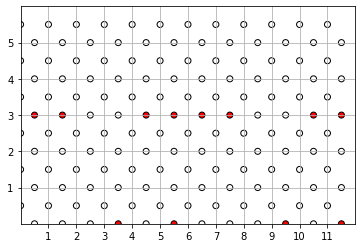

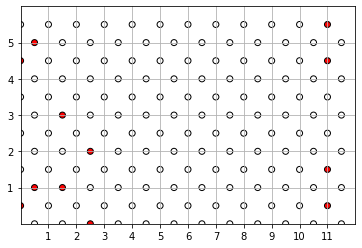

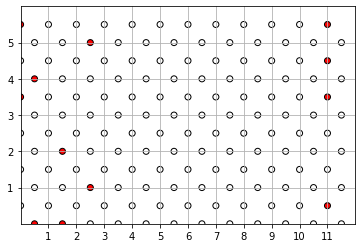

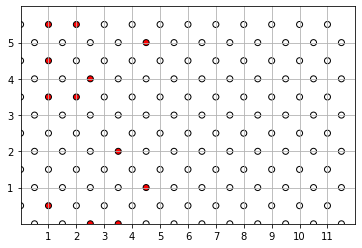

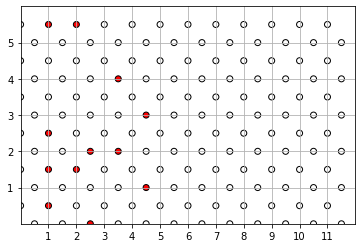

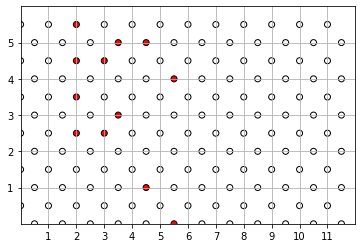

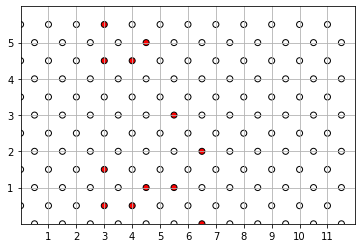

In [9]:
# Plot out the initial X logicals for the Gross code
x = []
y = []
for j in range(0,72):
    x.append(1/2 + np.floor(j/6))
    y.append((3-j) % 6)
for j in range(0,72):
    x.append((np.floor(j/6)-1) % 12)
    y.append(((-j % 6) + 3/2) % 6)

print('X logicals of the Gross code:')
for k in range(0,12):
    
    Xcolors = []
    for j in range(0,len(x)):
        if Lx[k,j] == 0:
            Xcolors.append('none')
        else:
            Xcolors.append('red')
    
    # plot
    fig, ax = plt.subplots()

    ax.scatter(x, y, facecolors=Xcolors, edgecolors='black')

    ax.set(xlim=(0, 12), xticks=np.arange(1, 12),
           ylim=(0, 6), yticks=np.arange(1, 6))

    ax.grid(True)
    
    # Uncomment below if you would like to save the figures
    plt.savefig("./TMP/GrossX" + str(k)+ ".png",dpi=300)
    plt.show()

Z logicals of the Gross code:


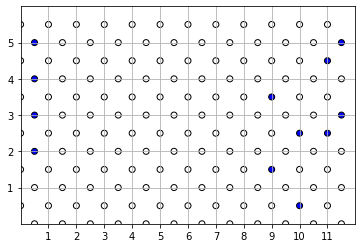

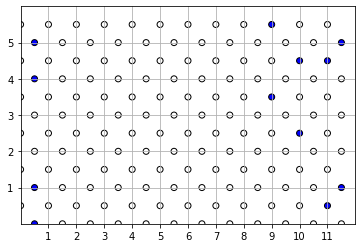

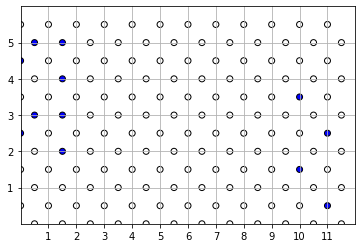

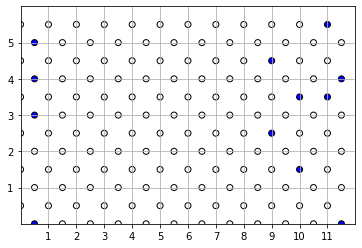

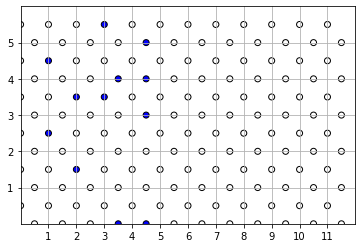

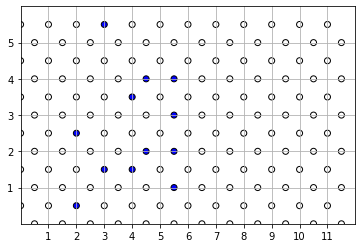

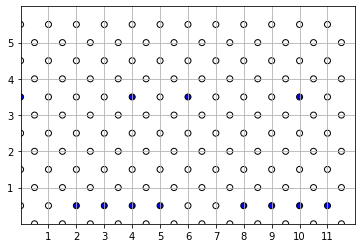

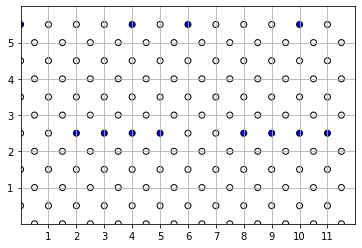

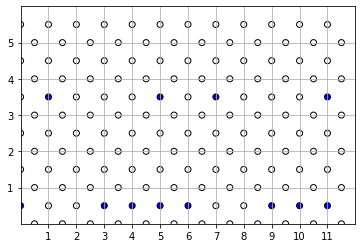

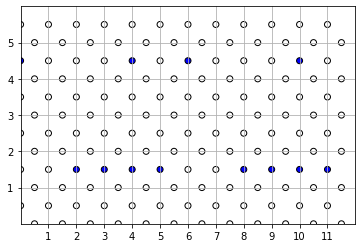

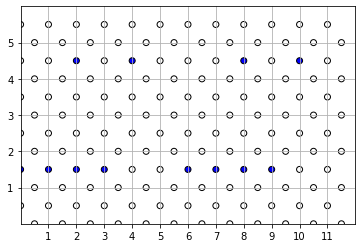

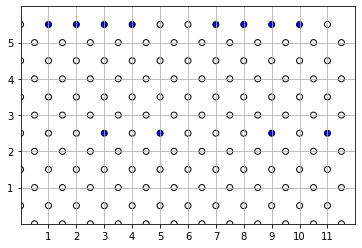

In [10]:
# Plot out the initial Z logicals for the Gross code
x = []
y = []
for j in range(0,72):
    x.append(1/2 + np.floor(j/6))
    y.append((3-j) % 6)
for j in range(0,72):
    x.append((np.floor(j/6)-1) % 12)
    y.append(((-j % 6) + 3/2) % 6)
#print(x)
#print(y)

print('Z logicals of the Gross code:')
for k in range(0,12):
    
    Zcolors = []
    for j in range(0,len(x)):
        if Lz[k,j] == 0:
            Zcolors.append('none')
        else:
            Zcolors.append('blue')
    
    # plot
    fig, ax = plt.subplots()

    ax.scatter(x, y, facecolors=Zcolors, edgecolors='black')

    ax.set(xlim=(0, 12), xticks=np.arange(1, 12),
           ylim=(0, 6), yticks=np.arange(1, 6))

    ax.grid(True)
    
    # Uncomment below if you would like to save the figures
    plt.savefig("./TMP/GrossZ" + str(k)+ ".png",dpi=300)
    plt.show()

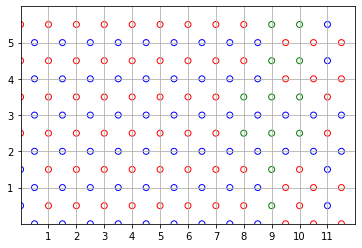

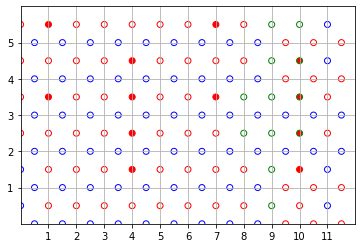

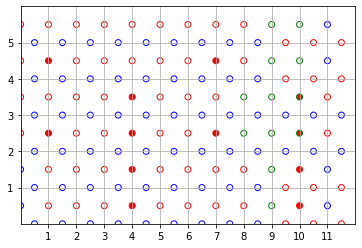

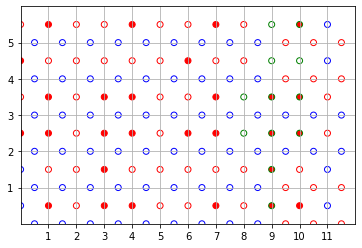

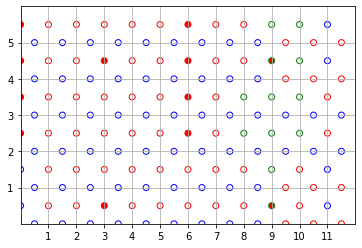

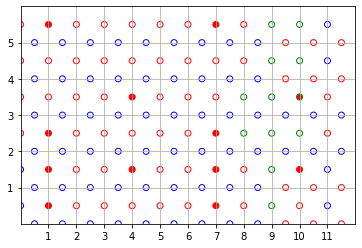

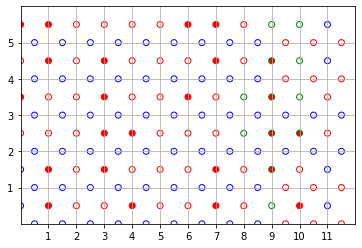

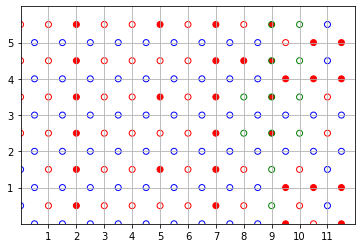

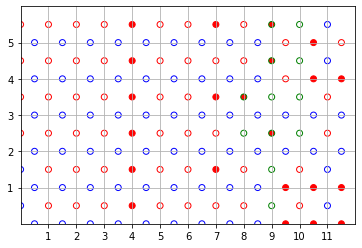

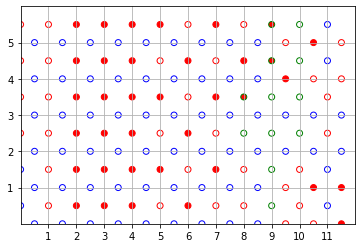

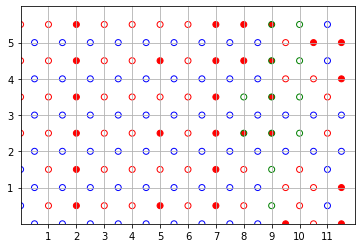

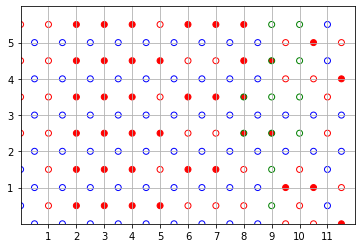

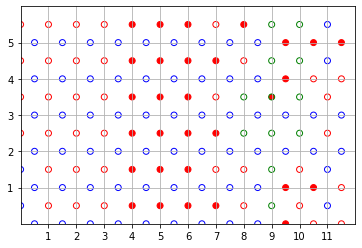

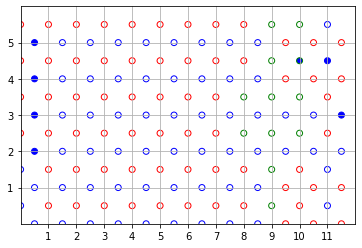

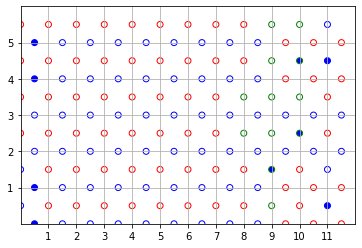

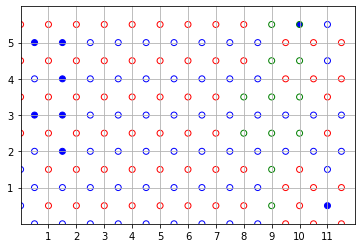

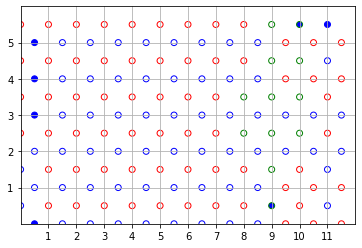

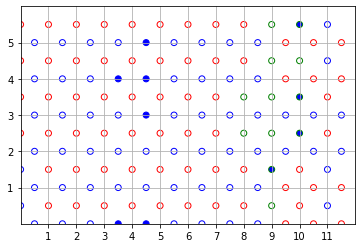

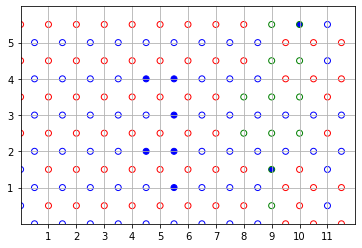

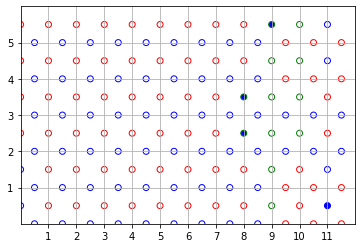

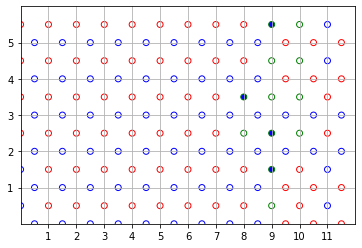

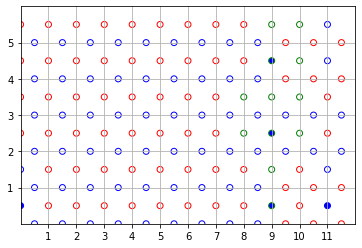

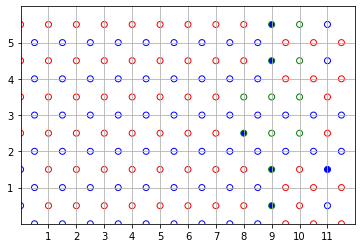

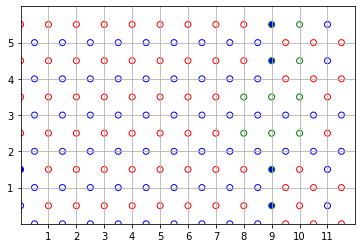

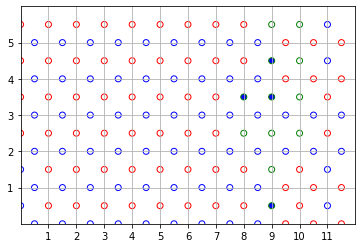

In [17]:
# Printing out the support of the modified Gross code logicals
x = []
y = []
for j in range(0,72):
    x.append(1/2 + np.floor(j/6))
    y.append((3-j) % 6)
for j in range(0,72):
    x.append((np.floor(j/6)-1) % 12)
    y.append(((-j % 6) + 3/2) % 6)
#print(x)
#print(y)

Zstabs = Zmeasured
Xstabs = Xmeasured
Scolors = []

for j in range(0,len(x)):
    if j in Zstabs:
        Scolors.append('blue')
    elif j in Xstabs:
        Scolors.append('red')
    elif j in SingleLogicals:
        Scolors.append('green')
    else:
        Scolors.append('black')
        
    
    
# plot
fig, ax = plt.subplots()

ax.scatter(x, y, facecolors='none', edgecolors=Scolors)
#ax.scatter(x, y, facecolors=Zcolors, edgecolors='black')

ax.set(xlim=(0, 12), xticks=np.arange(1, 12),
       ylim=(0, 6), yticks=np.arange(1, 6))

ax.grid(True)
# Uncomment below if you would like to save the figures    
#plt.savefig("Stabs"+".png",dpi=300)
plt.show()

# Plot out the modified (up to stabilizer) X logicals for the Gross code 

for k in range(0,12):
    
    Lcolors = []
    for j in range(0,len(x)):
        if SL_dec[144+k,j] == 0:
            Lcolors.append('none')
        else:
            Lcolors.append('red')
    
    # plot
    fig, ax = plt.subplots()

    ax.scatter(x, y, facecolors=Lcolors, edgecolors=Scolors)
    #ax.scatter(x, y, facecolors=Zcolors, edgecolors='black')

    ax.set(xlim=(0, 12), xticks=np.arange(1, 12),
           ylim=(0, 6), yticks=np.arange(1, 6))

    ax.grid(True)
    
    # Uncomment below if you would like to save the figures
    plt.savefig("./TMP/GrossXmod" + str(k)+ ".png",dpi=300)
    plt.show()
    
# Plot out the modified (up to stabilizer) Z logicals for the Gross code 

for k in range(0,12):
    
    Lcolors = []
    for j in range(0,len(x)):
        if SL_dec[156+k,144+j] == 0:
            Lcolors.append('none')
        else:
            Lcolors.append('blue')
    
    # plot
    fig, ax = plt.subplots()

    ax.scatter(x, y, facecolors=Lcolors, edgecolors=Scolors)
    #ax.scatter(x, y, facecolors=Zcolors, edgecolors='black')

    ax.set(xlim=(0, 12), xticks=np.arange(1, 12),
           ylim=(0, 6), yticks=np.arange(1, 6))

    ax.grid(True)
    
    # Uncomment below if you would like to save the figures
    plt.savefig("./TMP/GrossZmod" + str(k)+ ".png",dpi=300)
    plt.show()

In [29]:
# When we consider the logicals restricted to the set of qubits from SingleLogicals
Hx_dec = np.zeros((12,12),dtype=int)
Hz_dec = np.zeros((12,12),dtype=int)

for k in range(0,12):
    for j in range(0,12):
        idx = SingleLogicals[j]
        Hx_dec[k,j] = SL_dec[144+k,idx]
        Hz_dec[k,j] = SL_dec[156+k,idx+n]
        
print("The set of physical qubits storing the logical information are:")  
print(SingleLogicals)
print("The original X logicals have the following support on these qubits:")
print(Hx_dec)
print("The original Z logicals have the following support on these qubits:")
print(Hz_dec)
print("Checking the commutation of the logicals on these qubits:")
print(np.matmul(Hx_dec,np.transpose(Hz_dec)) % 2)



The set of physical qubits storing the logical information are:
[130, 131, 132, 133, 134, 135, 136, 137, 140, 141, 142, 143]
The original X logicals have the following support on these qubits:
[[0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 1 1 0 0 1 1 1 0 1 1]
 [0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 1 1 1 0 0 0 1]
 [0 0 0 0 1 1 1 1 0 0 0 0]
 [1 0 0 0 1 1 0 1 0 0 0 0]
 [1 0 0 0 1 1 0 0 0 0 0 0]
 [0 1 0 0 1 1 1 1 0 0 0 0]
 [1 1 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]]
The original Z logicals have the following support on these qubits:
[[0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 1 1]
 [0 0 1 0 0 0 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 1 0 0 0 0]
 [0 0 0 1 0 1 0 1 0 0 0 0]
 [0 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0]
 [1 0 0 1 0 1 1 0 0 0 0 0]]
Checking the commutation of the logicals on these qubits:
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 